In [1]:
import os
from sys import platform

import pyNetLogo

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

In [2]:
# add ( NetLogo : path )  as an environment variable
if platform == "linux":
    os.environ["NetLogo"] = "/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1"
    
for key in os.environ:
    if key.lower() == "netlogo":
        print(f"{key} -> {os.environ[key]}")

# connect to netlogo
netlogo = pyNetLogo.NetLogoLink(
    gui=False,
    netlogo_home = os.environ['NetLogo'],
    netlogo_version="6.2",
)

NetLogo -> /home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1


In [3]:
# load model
if platform == "linux":
    ku_model_path = os.path.abspath(os.getcwd()) + "/files/knowledge_units_with_board.nlogo"    
elif platform == "win32":
    ku_model_path = os.path.abspath(os.getcwd()) + "\\files\\knowledge_units_with_board.nlogo"

def load_model(path):
    netlogo.load_model(path)
    netlogo.command("set number_of_agents 15")
    netlogo.command("setup")
    netlogo.command("repeat 200 [go]")
    
load_model(ku_model_path)

In [ ]:
# change interface vars
# keys = [
#     "number_of_agents",
#     "ku_number",
#     "ku_len",
#     "c_threshold",
# ]
# values = [6, 9, 8, 0.5]

# experiment = {k: v for k, v in zip(keys, values)}to-report get-all-compatibilities

# Set the input parameters
# for key, value in zip(keys, values):
#     if key == "random-seed":
#         # The NetLogo random seed requires a different syntax
#         netlogo.command("random-seed {}".format(value))
#     else:
#         # Otherwise, assume the input parameters are global variables
#         netlogo.command(f"set {key} {value}")
# netlogo.command("set random-seed 250474")

In [4]:
def nd_array_to_compats(ndarr):
    compats = []
    curr_compat = []

    # iterate current and next element
    for curr, _next in zip(ndarr, ndarr[1:]):
        curr_compat.append(curr)

        # if next element is lower than current, a new instance started
        if _next < curr:
            # add compats and reset temp var
            compats.append(curr_compat)
            curr_compat = []

    # REMOVE FIRST ELEMENT
    compats[0].pop(0)

    return compats

# colours = ['red', 'green', 'blue']
def gen_graph(compatibilities):
    fig, ax = plt.subplots()
    ax.set_xlabel("Tick")
    ax.set_ylabel("Hamming Distances")
    ax.set_aspect(100)
    plt.title("Hamming Distances per Tick")
    # fig.set_size_inches(5, 5)

    plt.yticks([0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0])

    for index, compats in enumerate(compatibilities):
        if index % 10 == 0:
            for c, size in Counter(compats).items():
                # print(size)
                ax.scatter(x=index, y=c, s=(size**2), color="blue")  # color=colours[size%3]

    # sns.scatterplot(data= compatibilities)

    plt.savefig("files/new_plot.jpg", dpi=300, transparent=False)
    plt.show()


def plot_1d_arr(arr, ylabel, type="line",aspect=70):
    df = pd.DataFrame(arr)

    fig, ax = plt.subplots()
    ax.set_aspect(aspect)
    ax.set_xlabel("Tick")
    ax.set_ylabel(ylabel)
    fig.patch.set_facecolor('white')
    plt.title(f"{ylabel} / Tick")

    if type == "line":
        sns.lineplot(data=df, x=range(len(arr)), y=df[0])
    elif type == "scatter":
        sns.scatterplot(data=df, x=range(len(arr)), y=df[0])
    else:
        sns.barplot(data=df, x=range(len(arr)), y=df[0])
    
    # print(df.describe())

In [ ]:
# TODO : representar MELHOR quantas vezes cada valor é repetido
# violin plot?

netlogo.command("setup")
# run go 200 times
netlogo.command("repeat 200 [go]")

# returns an ndarray
report = netlogo.report("compats-report")
print(report)
gen_graph(nd_array_to_compats(report))

# TODO : m / f graphs

In [ ]:
netlogo.command("setup")
netlogo.command("repeat 200 [go]")

In [ ]:
netlogo.command("setup")
netlogo.command("repeat 200 [go]")

all_compat_ratios = netlogo.report("compat-ratio-report")

compat_df = pd.DataFrame(all_compat_ratios)
compat_df

fig, ax = plt.subplots()
ax.set_xlabel("Tick")
ax.set_ylabel("On Topic?")
plt.title("Topic Divergence")

# plt.yticks([-2.0, -1.0, 0.0, 1.0, 2.0])

sns.lineplot(data=compat_df, x=range(201), y=compat_df[0])

print(compat_df.describe())



In [5]:
def show_sim_stats():
    """prints graph pertaining to the ran simulation"""
    plot_1d_arr(netlogo.report("burst-length-report"), ylabel="Burst Length", type="line", aspect=20)
    # save_to_file("burst_lengths", netlogo.report("burst-length-report"))
    participation = netlogo.report("mf-participation-report")
    female_part = participation[1::2] # Elements from list1 starting from 1 iterating by 2
    male_part = participation[::2]

    plot_1d_arr(female_part, ylabel="F Participation", type="line")
    plot_1d_arr(male_part, ylabel="M Participation", type="line")


def save_to_file(file_name, content):
    with open(f"outputs/{file_name}.csv", "w+") as fp:
        fp.write(content.tostring())

def read_from_file(file_name):
    with open(f"{file_name}") as fp:
        return np.fromstring(fp.readlines(),  dtype=int)

# ts = arr.tostring()
# print(np.fromstring(ts, dtype=int))
# show_sim_stats()


def show_topic_divergence(scenario):
    topic = [[],[]]

    messages = netlogo.report("get-in-topic").astype(int)
    # should_be = [[2, 1, 3], [3, 1, 1, 4]]

    with open(f"outputs/{scenario}_in-topic-data.csv", "a+") as fp:
        fp.write(f"{list(messages)}")
        fp.write("\n")
    
    prev_compat = False

    for curr_compat in messages:
        
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat])-1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat

    # print(topic)

    sns.displot(topic[0], kde=True).set(title="Lengths of Out-of-Topic Discussions")
    x_ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    plt.xticks(x_ticks)

    sns.displot(topic[1], kde=True).set(title="Lengths of In-Topic Discussions")

In [ ]:
# attempt to read from file
# with open(f"outputs/aboubakar.csv", "wb+") as fp:
#     fp.write(netlogo.report("burst-length-report"))
    
# print(read_from_file("outputs/aboubakar.csv"))

In [6]:
def run_scenario(method, females, males, f_exploit, m_exploit, scenario, iterations = 5):
    netlogo.command(f'set Method "Attention Norm - {method}"')
    netlogo.command(f'set females {females}')
    netlogo.command(f'set males {males}')
    netlogo.command(f'set female_prob_exploit {f_exploit}')
    netlogo.command(f'set male_prob_exploit {m_exploit}')
    
    for _ in range(iterations):    
        netlogo.command("setup")
        netlogo.command("repeat 200 [go]")

        messages = netlogo.report("get-in-topic").astype(int)
        with open(f"outputs/{scenario}_in-topic-data.csv", "a+") as fp:
            fp.write(f"{list(messages)}")
            fp.write("\n")

    read_in_topic(scenario)
    #  read divergence from file
    # show_topic_divergence(scenario)
    # show_sim_stats()

In [7]:
scenarios = {
    # Scenario:sub-scenario : [Attentio Norm, females, males, female_prob_exploit, male_prob_exploit]
    # Working class
    1.1 : ["General", 1, 1, 0.65, 0.25],
    1.2 : ["General", 2, 1, 0.65, 0.25],
    1.3 : ["Gendered", 2, 1, 0.65, 0.25],
    
    # Middle class
    2.1 : ["General", 1, 1, 0.7, 0.5],
    2.2 : ["General", 2, 1, 0.7, 0.5],
    2.3 : ["Gendered", 2, 1, 0.7, 0.5],
    
    # Upper class
    3.1 : ["General", 1, 1, 0.85, 0.75],
    3.2 : ["General", 2, 1, 0.85, 0.75],
    3.3 : ["Gendered", 2, 1, 0.85, 0.75],
}

# run_scenario(*scenarios[1.1], 1.1, 50)

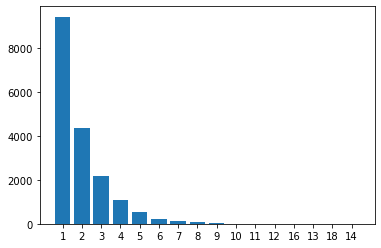

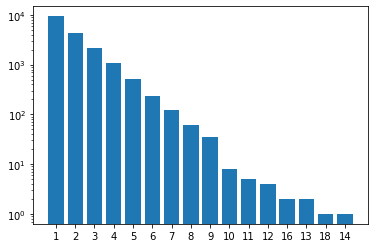

In [10]:
data = {1: 9426, 2: 4367, 3: 2157, 4: 1079, 5: 517, 6: 234, 7: 123, 8: 61, 9: 36, 10: 8, 11: 5, 12: 4, 16: 2, 13: 2, 18: 1, 14: 1}
# data = run_scenario(*scenarios[1.1], 1.1, 50)

ind = np.arange(len(data))

plt.bar(ind, list(data.values()))
plt.xticks(ind, list(data.keys()))
plt.show()

plt.bar(ind, list(data.values()))
plt.xticks(ind, list(data.keys()))
plt.yscale("log")
plt.show()


In [ ]:
def add_topics(messages):
    topic = [[],[]]
    
    prev_compat = 1 - messages[0]

    for curr_compat in messages:
        # print(curr_compat)
        if prev_compat == curr_compat: # continue last count
            topic[curr_compat][len(topic[curr_compat])-1] += 1
        else: # create new count
            topic[curr_compat].append(1)
        
        prev_compat = curr_compat
    
    return topic

In [174]:
def read_in_topic(scenario):
    in_topic = []
    out_topic = []

    with open(f"outputs/{scenario}_in-topic-data.csv") as fp:
        
        for l in fp.readlines():
            lst = [int(e) for e in l if e.isalnum()]
            
            # print(add_topics(lst))
            topics = add_topics(lst)
            out_topic += topics[0]
            in_topic += topics[1]
            # print(f"out {out_topic}")
            # print(f"in  {all_topics[1]}")

    print(Counter(in_topic))

    # msgs = ([''.join(e for e in l if e.isalnum()) for l in fp.readlines()])
    # msgs = list(itertools.chain(*msgs))

In [12]:
load_model(ku_model_path)


array([1., 0., 1., ..., 0., 1., 0.])

In [14]:
in_out_topic = netlogo.report("get-in-topic").astype(int)

1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0


In [18]:
print(*in_out_topic)

1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 

1.1
1.2
1.3
2.1
2.2
2.3
3.1
3.2
3.3


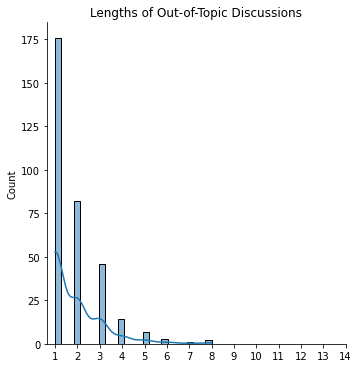

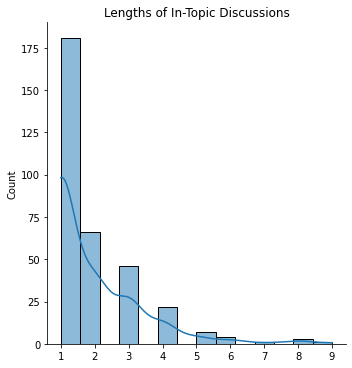

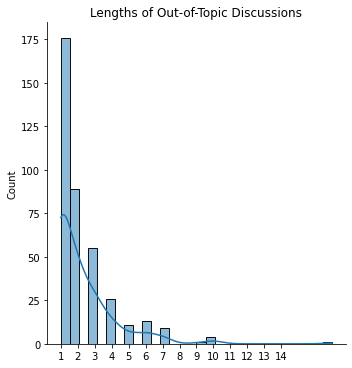

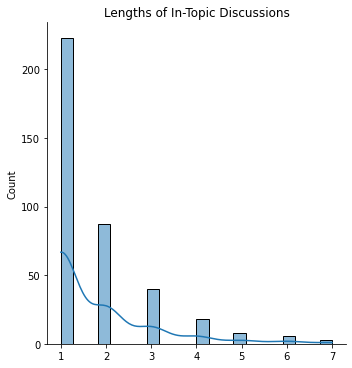

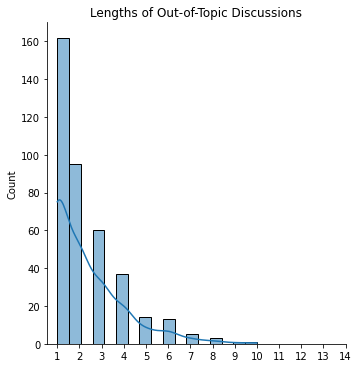

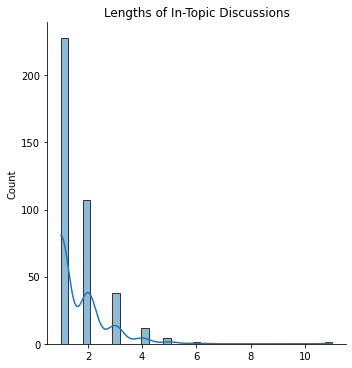

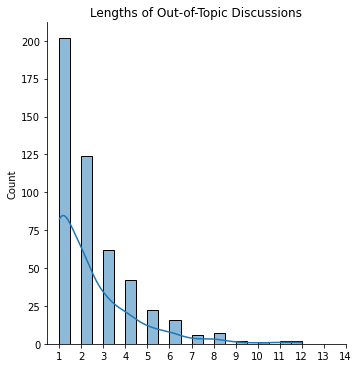

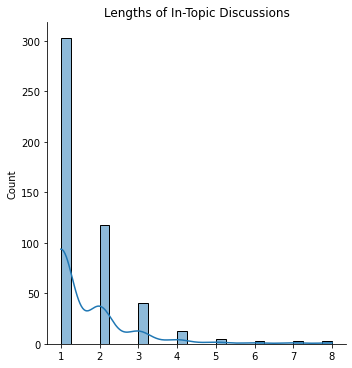

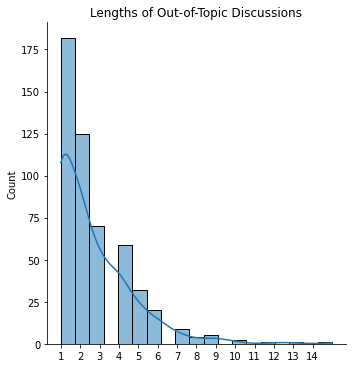

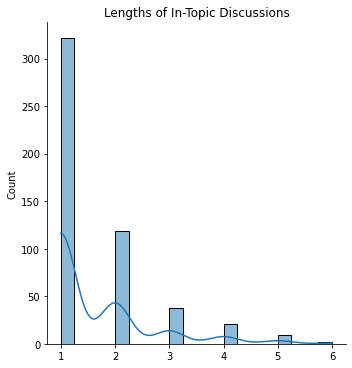

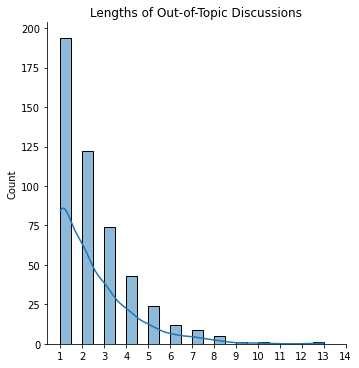

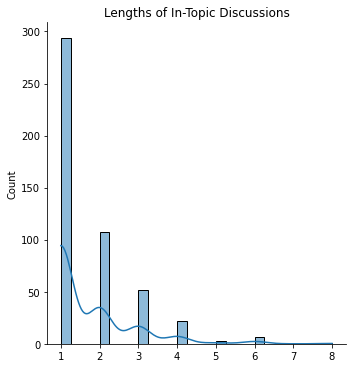

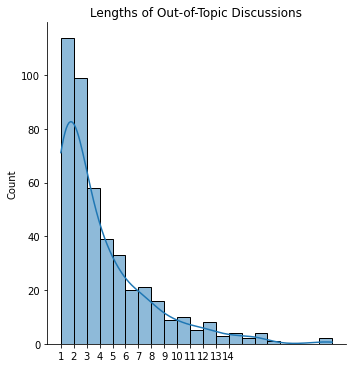

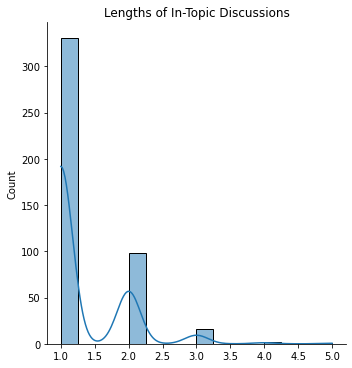

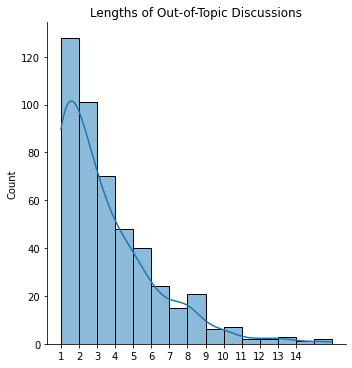

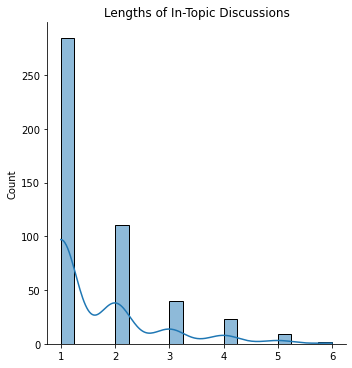

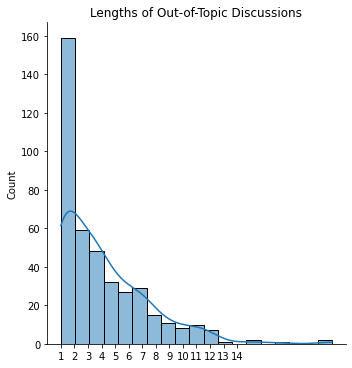

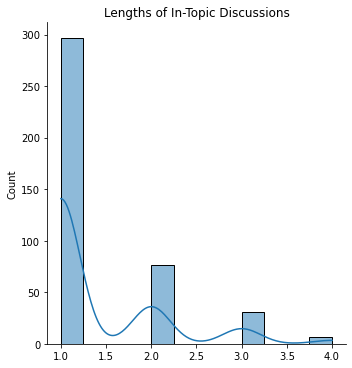

In [57]:
for k,v in scenarios.items():
    print(k)
    run_scenario(*v, k)

TODO : 
- guardar dados da simulação em ficheiros
- criar plots com info dos ficheiros

